In [1]:
import sys
sys.path.append("..\\scripts\\")
import torch 
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import numpy as np
import matplotlib.pyplot as plt
from torch.func import vmap, grad
from tqdm import tqdm
from scipy.stats import binned_statistic_2d

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 10
from score_models import ScoreModel, NCSNpp
import json
from mpol import coordinates
from mpol.gridding import DirtyImager

plt.style.use("dark_background")

from utils import fits_to_tensor, link_function
device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
file = open("../../ncsnpp_ct_g_220912024942/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

# Importing the weights
score_model = ScoreModel(checkpoints_directory="../../ncsnpp_ct_g_220912024942")

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

def ift(x): 
    return torch.fft.ifft2(x, norm = "ortho")


# Observation
data = np.load("../../htlup_continuum.npz")
u = data["u"] # klambda units
v = data["v"]
vis_real = data["vis_real"]
vis_imag = data["vis_imag"]
wavelength = data["wavelength"]
weight = data["weight"]

# Loading the psf and the dirty image
pixel_scale = 0.0015 # arcsec
npix = 256 # Number of pixels in the grid
coords = coordinates.GridCoords(cell_size=pixel_scale, npix=npix)
img_size = 256 # Number of pixels in the reconstructed image

nchan = vis_real.shape[0]
data_size = vis_real.shape[-1]


# imgs = []
# beams =[]
# for channel in range(8):
#     imager = DirtyImager(
#         coords=coords,
#         uu=u * np.ones(shape = ()),
#         vv=v,
#         weight=weight,
#         data_re=vis_real[channel],
#         data_im=vis_imag[channel]
#     )
#     dirty_image, beam = imager.get_dirty_image(weighting="briggs", robust=0.05, max_scatter = 100)
#     imgs.append(dirty_image)
#     beams.append(beam)

imager = DirtyImager(
        coords=coords,
        uu=u * np.ones(shape = (nchan, data_size)),
        vv=v * np.ones(shape = (nchan, data_size)),
        weight=weight * np.ones(shape = (nchan, data_size)),
        data_re=vis_real,
        data_im=vis_imag
    )
dirty_image, beam = imager.get_dirty_image(weighting="briggs", robust=0.05, max_scatter = 100)

In [22]:
std_bin_real.shape

(262144,)

In [ ]:
std_bin_real.

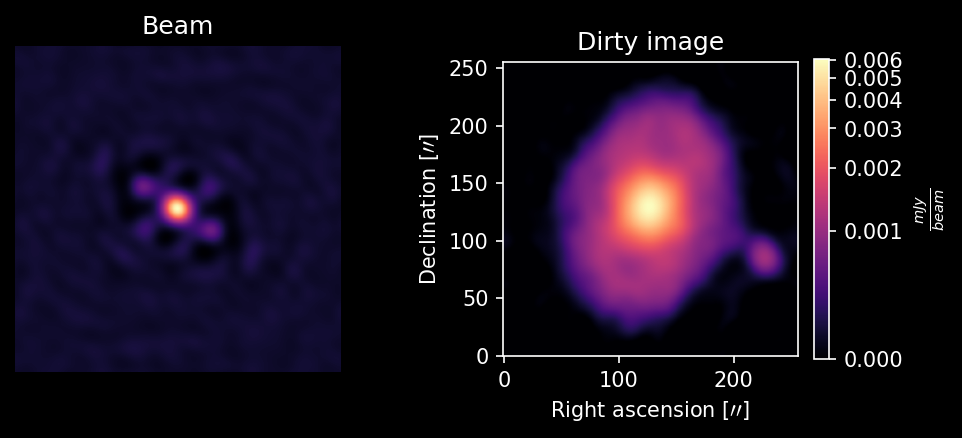

In [35]:
dirty_image, beam = torch.tensor(dirty_image.copy()).to(device), torch.tensor(beam.copy()).to(device)
dirty_image, beam = dirty_image.mean(axis = 0), beam.mean(axis = 0)
sampling_function = ft(torch.fft.ifftshift(beam)).flatten()

# Plotting... 
fig, axs = plt.subplots(nrows= 1 , ncols = 2, figsize = (7, 3.5))
axs[0].axis("off")

axs[0].imshow(beam.squeeze().real.cpu(), cmap = "magma", origin = "lower")
axs[0].set_title("Beam")

norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
im = axs[1].imshow((dirty_image).squeeze().real.cpu(), cmap =  "magma", norm = norm, origin = "lower")
axs[1].set(title = "Dirty image", xlabel = r"Right ascension $[\prime\prime]$", ylabel = r"Declination $[\prime\prime]$")
plt.colorbar(im, fraction = 0.046, label = r"$\frac{mJy}{beam}$")
plt.subplots_adjust(wspace = 0.5)

In [1]:
bin_x = coords.u_edges
bin_y = coords.v_edges
std_bin_real, edgex, edgey, binumber = binned_statistic_2d(u, v, vis_real, "std", (bin_x, bin_y))
std_bin_imag, edgex, edgey, binumber = binned_statistic_2d(u, v, vis_imag,  "std", (bin_x, bin_y))

count, *_ = binned_statistic_2d(u, v, vis_real, "count", (bin_x, bin_y))
count.shape

std_real = (std_bin_real / (count + 1)).mean(axis = 0)
std_imag = (std_bin_imag / (count + 1)).mean(axis = 0)

print(std_real.mean())
std_bin_real[np.isnan(std_bin_real)] = 1e-3
std_bin_imag[np.isnan(std_bin_imag)] = 1e-3

std_bin_real = torch.tensor(std_bin_real.mean(axis = 0).flatten()).to(device)
std_bin_imag = torch.tensor(std_bin_imag.mean(axis = 0).flatten()).to(device)



NameError: name 'coords' is not defined

In [56]:
print(std_real[~np.isnan(std_real)].max())
print(std_imag[~np.isnan(std_imag)].max())

0.007442099769023474
0.00698102672927056


In [58]:
# To handle pytorch's problem to do differentiation on complex 
y = ft(dirty_image/dirty_image.max()).flatten()

D = len(y)
sigma_likelihood = 1e-5 # My guess 
beta = 0
def sigma(t): 
    return sigma_min * (sigma_max/sigma_min) ** t


def model(x):
    x = x.reshape(img_size, img_size)
    x = link_function(x)
    pad_size = int((npix - img_size)/2)
    x = torch.nn.functional.pad(x, (pad_size, pad_size, pad_size, pad_size))  # 256 > npix
    vis_full = ft(x).flatten()
    sampling_function= ft(beam).flatten()

    # To prevent problems with grad for complex functions in torch
    vis_sampled = vis_full * sampling_function
    return vis_sampled

S = sampling_function

def logprob_likelihood(z, var): 
    """Calculate the log-likelihood of a Multivariate Gaussian for a diagonal covariance matrix

    Args:
        x: point where we want to compute the log-likelihood
        sigmas: Tensor containing the elements of the diagonal of the covariance matrix 

    Returns:
        log-likelihood
    """

    #inv_cov = torch.diag(1/sigmas)
    val = - (z.conj().t() *1/var) @ z # - D/2 * np.log(2*np.pi) - 1/2 * torch.log(torch.prod(sigmas))
    return val.squeeze(0)

def logprob_likelihood2(y, x, sigma, A): 
    y
    val = - (y-A(x))

def score_likelihood(x, t): 
    I = torch.ones(D).to(device)
    cov_noise = std_bin_real **2 + std_bin_imag**2 * 1j  
    return vmap(grad(lambda x, t: logprob_likelihood(y -model(x), cov_noise + sigma(t)**2 * (S.abs()**2 + beta * I))))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    return score_model.score(t, x.reshape(-1, 1, img_size, img_size)).flatten(start_dim = 1) + score_likelihood(x, t)

x = torch.randn([1, img_size ** 2]).to(device) 
t = torch.ones([1]).to(device)

print((torch.sum(score_likelihood(x, t)**2))**0.5)
print(score_posterior(x, t))
#score_model.score(t, x.reshape(-1, 1, img_size, img_size)).shape 


tensor(0.0017, device='cuda:0')
tensor([[-0.0003, -0.0050, -0.0014,  ...,  0.0048,  0.0050,  0.0013]],
       device='cuda:0', grad_fn=<AddBackward0>)



$$
y = S\mathcal{F}x + \eta
$$

$$
A A^\ast = (SF)(SF)^\ast = |S|^2
$$

In [ ]:
def logprob_likelihood(y, x, var, A): 
    """Calculate the log-likelihood of a Multivariate Gaussian for a diagonal covariance matrix

    Args:
        x: point where we want to compute the log-likelihood
        sigmas: Tensor containing the elements of the diagonal of the covariance matrix 

    Returns:
        log-likelihood
    """

    #inv_cov = torch.diag(1/sigmas)
    val = - (z.conj().t() *1/var) @ z # - D/2 * np.log(2*np.pi) - 1/2 * torch.log(torch.prod(sigmas))
    return val.squeeze(0)

In [7]:
S.shape

torch.Size([262144])

In [156]:
std_bin_real.shape

torch.Size([8, 512, 512])

In [59]:
def g(t): 
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
            
    return link_function(x_mean) * dirty_image.max()

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma_max * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return link_function(x_mean) * dirty_image.max()

pred = 500
corr = 100
snr = 1e-2
samples = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = img_size)
#samples = pc_sampler(num_samples = 4, num_pred_steps = pred, num_corr_steps = corr, snr = snr, score_function = score_posterior, img_size = img_size)

100%|██████████| 499/499 [01:48<00:00,  4.59it/s]


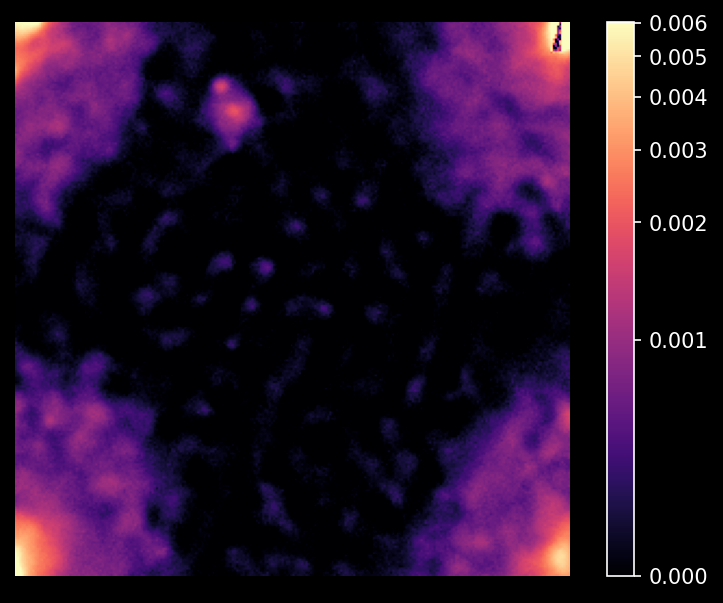

In [60]:
n_images = len(samples)
grid_size = int(n_images**0.5)
norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))

    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((samples[k]).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    plt.imshow((samples).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
    plt.colorbar()

In [57]:
I = torch.ones(D).to(device)

In [61]:
S.shape

torch.Size([1, 512, 512])

In [58]:
D

262144